## Allan Deviation - Statistics Overview

In [130]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from pandas import read_pickle
from andbro__querrySeismoData import __querrySeismoData
from andbro__read_sds import __read_sds

from andbro__store_as_pickle import __store_as_pickle

In [4]:
from functions.load_beat_data import __load_beat_data
from functions.get_time_intervals import __get_time_intervals
from functions.get_median import __get_median
from functions.get_minimum import __get_minimum
from functions.get_percentiles import __get_percentiles
from functions.load_mlti import __load_mlti
# from functions.get_mlti_intervals import __get_mlti_intervals
# from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN


In [118]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [119]:
## Configuration
config = {}

config['path_to_figures'] = data_path+"allan_deviation/figures/"

config['path_to_data'] = data_path+"allan_deviation/data/"

config['relative'] = False


## Plot Mutli Allan

In [125]:
# adev_Z = read_pickle(config['path_to_data_out']+"ADev_Z_2023-09-19.pkl")
# adev_U = read_pickle(config['path_to_data_out']+"ADev_U_2023-09-19.pkl")
# adev_V = read_pickle(config['path_to_data_out']+"ADev_V_2023-09-19.pkl")

adev_Z = read_pickle(config['path_to_data']+"ADev_ROMY_Z_2024-04-20.pkl")
adev_U = read_pickle(config['path_to_data']+"ADev_ROMY_U_2024-04-20.pkl")
adev_V = read_pickle(config['path_to_data']+"ADev_ROMY_V_2024-04-20.pkl")

adev_ZZ = read_pickle(config['path_to_data']+"ADev_RLAS_Z_2024-04-20.pkl")


# allans = [adev_Z, adev_U, adev_V]
allans = [adev_Z, adev_U, adev_V, adev_ZZ]

## Geophysical Signals

In [135]:
geo = {}

geo['semi_diurnal_tides'] = {'poly':[(3.2e4, 7e-13), (4.3e4, 7e-13), (4.3e4, 2.5e-12), (3.2e4, 2.5e-12)],
                             'label':'semi-diurnal\nEarth tides', 'labelxy':(2e3, 2e-12)
                            }
geo['diurnal_polar_motion'] = {'poly':[(6.7e4, 1.1e-12), (9e4, 1.1e-12), (9e4, 5.7e-12), (6.7e4, 5.7e-12)],
                                    'label':'diurnal\n polar\nmotion', 'labelxy':(1.1e5, 4e-12)
                                    }
geo['OAM_AAM'] = {'poly':[(5e5, 1e-13), (2.3e7, 1e-13), (2.3e7, 2.5e-12), (1.1e7, 2.5e-12), (5e5, 3.5e-13)],
                  'label':'OAM\nAAM', 'labelxy':(3e6, 3e-13)
                 }
geo['zonal_Earth_tides'] = {'poly':[(9.3e5, 1.4e-13), (1.23e6, 1.4e-13), (1.23e6, 6.6e-13), (9.3e5, 6.6e-13)],
                            'label':'zonal\nEarth\ntides', 'labelxy':(6e5, 1e-12)
                           }
geo['annual_polar_motion'] = {'poly':[(2.1e7,1e-11), (2.7e7, 1e-11), (2.7e7, 2.8e-11), (2.1e7, 2.8e-11)],
                              'label':'annual\n polar\nmotion', 'labelxy':(3e6, 9e-12)
                             }
geo['Chandler_wobble'] = {'poly':[(2.9e7, 2.1e-11), (3.9e7, 2.1e-11), (3.9e7, 9.3e-11), (2.9e7, 9.3e-11)],
                         'label':'Chandler wobble', 'labelxy':(6e5, 5e-11)
                         }
geo['seismic_waves'] = {'poly':[(1e-2, 2.1e-11), (, 2.1e-11), (30e1, 9.3e-11), (1e-2, 9.3e-11)],
                         'label':'seismic waves', 'labelxy':(1e2, 5e-11)
                         }


__store_as_pickle(geo, config['path_to_data']+"allan_geosignals.pkl")

(10.0, 100000000.0)

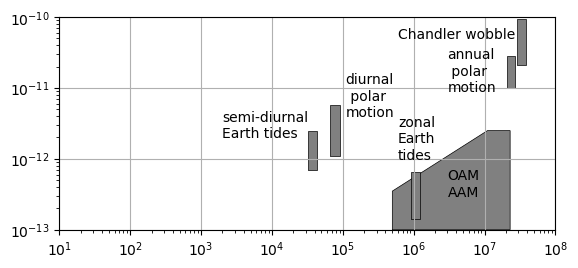

In [133]:
import shapely.plotting
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

plt.figure()

for k in geo.keys():
    polygon = Polygon(geo[k]['poly'])
    shapely.plotting.plot_polygon(polygon, add_points=False, facecolor="grey", edgecolor="black", lw=0.5)
    plt.text(geo[k]['labelxy'][0], geo[k]['labelxy'][1], f"{geo[k]['label']}")

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-13, 1e-10)
plt.xlim(1e1, 1e8)

## Plotting

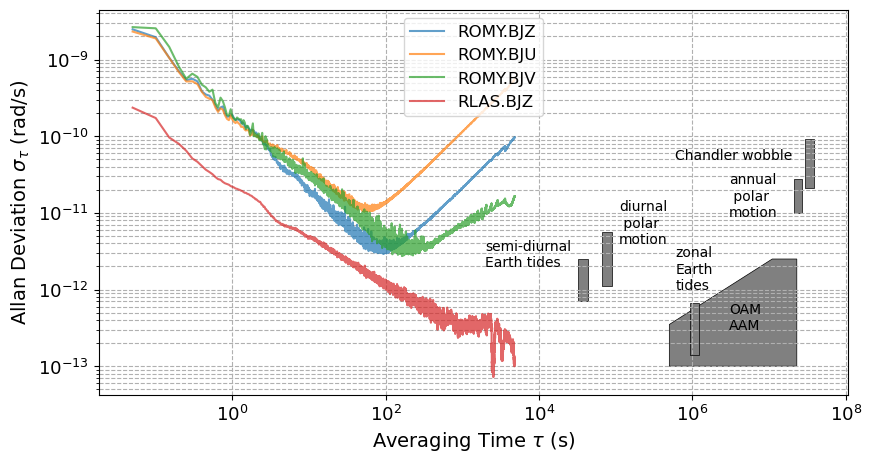

In [128]:
def __makeplot_allan_deviation_rings(allans, errorbars=False):

    # taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    # day = st[0].stats.starttime.date
    # tt1 = str(st[0].stats.starttime.time)[:8]
    # tt2 = str(st[0].stats.endtime.time)[:8]

    # if config['relative']:
    #     adev = adev / 7.3e-5

    ## -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    font = 14

    # tscale, tunit = 1/86400, "days"
    tscale, tunit = 1, "s"

    for _allan in allans:
        taus = _allan['tau']
        adev = _allan['adev']

        net, sta, loc, cha = _allan['seed'].split(".")

        if errorbars:
            ax.scatter(taus*tscale, adev, color='darkred', label=f"{sta}.{cha}", zorder=2)
            ax.errorbar(taus*tscale, adev, yerr=_allan[2], color='darkred', fmt='none', zorder=1)
        else:
            ax.plot(taus*tscale, adev, label=f"{sta}.{cha}", alpha=0.7)

    for k in geo.keys():
        polygon = Polygon(geo[k]['poly'])
        shapely.plotting.plot_polygon(polygon, add_points=False, facecolor="grey", edgecolor="black", lw=0.5)
        plt.text(geo[k]['labelxy'][0], geo[k]['labelxy'][1], f"{geo[k]['label']}")

    # ax.set_title(f"Allan Deviation for {config['net']}.{config['cha']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    tau = r"$\tau$"
    ax.set_xlabel(f"Averaging Time {tau} ({tunit})", fontsize=font)

    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ (rad/s)", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(loc=9, fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    return fig

fig = __makeplot_allan_deviation_rings(allans)

fig.savefig(config['path_to_figures']+f"ADev_ROMY_rings.jpeg", format="jpeg", dpi=150, bbox_inches='tight')


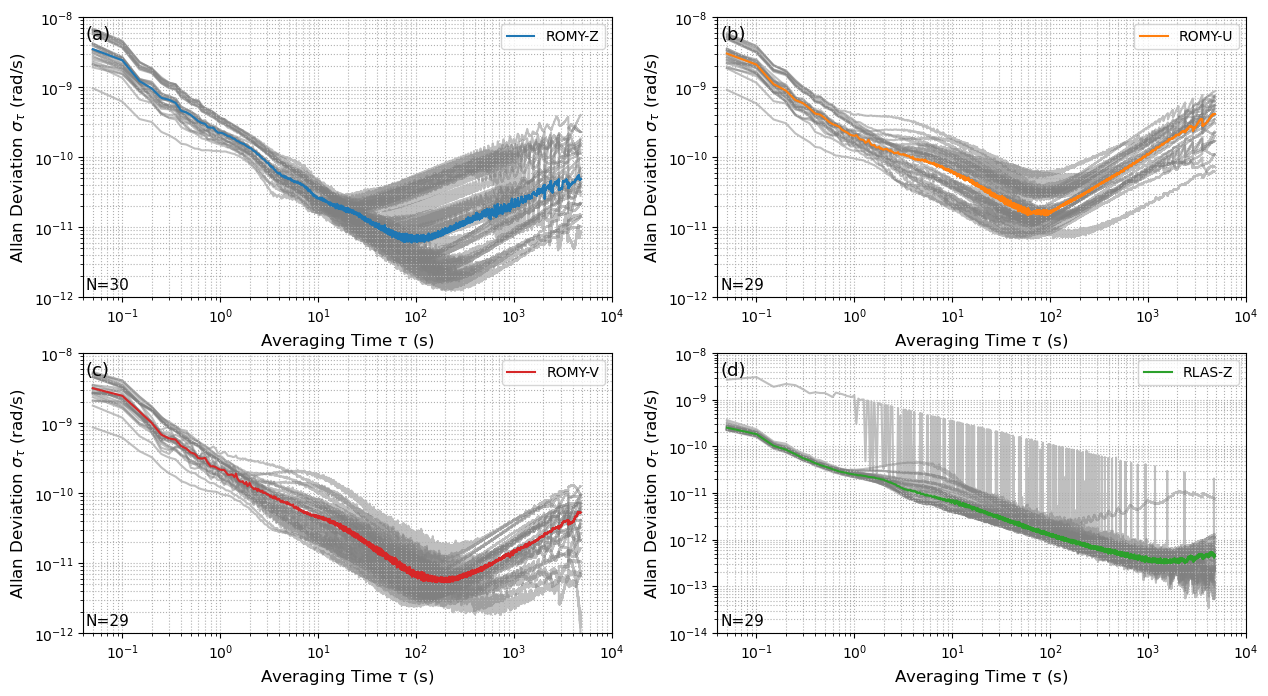

In [129]:
def __makeplot():

    Nrow, Ncol = 2, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))


    ax[0, 0].plot(adev_Z['tau'], adev_Z['adev_median'], ls="-", color="tab:blue", label="ROMY-Z", zorder=2)
    for a in adev_Z['adevs']:
        ax[0, 0].plot(adev_Z['tau'], a, ls="-", color="grey", alpha=0.5, zorder=1)

    ax[0, 1].plot(adev_U['tau'], adev_U['adev_median'], ls="-", color="tab:orange", label="ROMY-U")
    for a in adev_U['adevs']:
        ax[0, 1].plot(adev_U['tau'], a, ls="-", color="grey", alpha=0.5, zorder=1)

    ax[1, 0].plot(adev_V['tau'], adev_V['adev_median'], ls="-", color="tab:red", label="ROMY-V")
    for a in adev_V['adevs']:
        ax[1, 0].plot(adev_V['tau'], a, ls="-", color="grey", alpha=0.5, zorder=1)

    ax[1, 1].plot(adev_ZZ['tau'], adev_ZZ['adev_median'], ls="-", color="tab:green", label="RLAS-Z")
    for a in adev_ZZ['adevs']:
        ax[1, 1].plot(adev_ZZ['tau'], a, ls="-", color="grey", alpha=0.5, zorder=1)

    ax[0, 0].set_ylim(1e-12, 1e-8)
    ax[0, 1].set_ylim(1e-12, 1e-8)
    ax[1, 0].set_ylim(1e-12, 1e-8)
    ax[1, 1].set_ylim(1e-14, 1e-8)

    ax[0, 0].text(0.005, 0.97, "(a)", ha="left", va="top", transform=ax[0, 0].transAxes, fontsize=font+1)
    ax[0, 1].text(0.005, 0.97, "(b)", ha="left", va="top", transform=ax[0, 1].transAxes, fontsize=font+1)
    ax[1, 0].text(0.005, 0.97, "(c)", ha="left", va="top", transform=ax[1, 0].transAxes, fontsize=font+1)
    ax[1, 1].text(0.005, 0.97, "(d)", ha="left", va="top", transform=ax[1, 1].transAxes, fontsize=font+1)

    ax[0, 0].text(0.005, 0.07, f"N={adev_Z['adevs'].shape[0]}", ha="left", va="top", transform=ax[0, 0].transAxes, fontsize=font-1)
    ax[0, 1].text(0.005, 0.07, f"N={adev_U['adevs'].shape[0]}", ha="left", va="top", transform=ax[0, 1].transAxes, fontsize=font-1)
    ax[1, 0].text(0.005, 0.07, f"N={adev_V['adevs'].shape[0]}", ha="left", va="top", transform=ax[1, 0].transAxes, fontsize=font-1)
    ax[1, 1].text(0.005, 0.07, f"N={adev_ZZ['adevs'].shape[0]}", ha="left", va="top", transform=ax[1, 1].transAxes, fontsize=font-1)

    for i in range(Nrow):
        for j in range(Ncol):

            ax[i, j].grid(which="both", ls=":", zorder=0)
            ax[i, j].legend(loc=1)
            ax[i, j].set_xscale("log")
            ax[i, j].set_yscale("log")
            ax[i, j].set_xlim(4e-2, 1e4)

            ax[i, j].set_xlabel(r"Averaging Time $\tau$ (s)", fontsize=font)
            ax[i, j].set_ylabel(r"Allan Deviation $\sigma_{\tau}$ (rad/s)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figures']+f"ADev_ZUVW_individual.png", format="png", dpi=150, bbox_inches='tight')



In [9]:
def __makeplot_allan_deviation_statistics():

    # taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]


    ## -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    font = 14

    for _adev, _err in zip(adev, error):
        if config['errorbars']:
            ax.scatter(tau, _adev, color='grey', zorder=2, alpha=0.7)
            ax.errorbar(tau, _adev, yerr=_err, color='darkred', fmt='none', zorder=1)
        else:
            ax.plot(tau, _adev, color='grey', alpha=0.7)

    ## add median
    ax.plot(tau, adev_median, color='black')

    ## add minimum
    # ax.plot(tau, adev_minimum, color='black')

    ## add percentiles
    # ax.fill_between(tau, adev_perc_low, adev_perc_high, color='lightgrey')

    ax.set_title(f"Allan Deviation for {config['sta']}.{config['cha']}  | Twin={int(config['interval_seconds']/3600)}h ({int(config['interval_overlap']*100)}%) | {config['tbeg'].date} - {config['tend'].date}", fontsize=font+1)
    ax.set_xlabel(r"Averaging Time $\tau$ [s]", fontsize=font)

    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    return fig

# fig = __makeplot_allan_deviation_statistics()

# fig.savefig(config['path_to_figures']+f"AD_{config['seed'].split('.')[1]}_{config['cha'][-1]}_statistics.jpeg", format="jpeg", dpi=150, bbox_inches='tight')
